# Arranging Participant Data into Groups

In [8]:
import h5py, util
import numpy as np
import matplotlib.pyplot as plt

if 'h5' in globals():
    h5.close()

h5 = h5py.File('anonomisedData.hdf5', mode = 'r')
num_experiments = len(h5['participantRatings'])

In [26]:
h5.keys()

<KeysViewHDF5 ['comparativeAudioNames', 'dissimMatrix', 'dissimMatrix15Dims', 'mds2d', 'mds3d', 'pageInfo', 'participantInfo', 'participantRatings', 'rearrangedDissimMatrix', 'rearrangedReferenceAudioNames', 'referenceAudioNames', 'repeatComparativeAudioNames', 'repeatParticipantRatings', 'repeatReferenceAudioNames']>

### The 'participantInfo' key of the h5 file contains the following information about the participant:
0. Their corresponding Xml file name (not publically available)
1. The session set they were given to evaluate
2. The date and 
3. time they participated
4. Email address (not publically available)
5. Listening Equipment (1-inbuilt speakers, 2-external speaker, 3-ear/headphones)
6. Listening Environment (1(very noisy) - 5 (very quiet))
7. Age
8. Gender
9. Gold-MSI 'Perceptual Abilities' Question 1 - see Mullensiefen (2014) for response types
10. Gold-MSI 'Perceptual Abilities' Question 2 - see Mullensiefen (2014) for response types
11. Gold-MSI 'Perceptual Abilities' Question 3 - see Mullensiefen (2014) for response types
12. Gold-MSI 'Perceptual Abilities' Question 4 - see Mullensiefen (2014) for response types
13. Gold-MSI 'Perceptual Abilities' Question 5 - see Mullensiefen (2014) for response types
14. Gold-MSI 'Perceptual Abilities' Question 6 - see Mullensiefen (2014) for response types
15. Gold-MSI 'Perceptual Abilities' Question 7 - see Mullensiefen (2014) for response types
16. Gold-MSI 'Perceptual Abilities' Question 8 - see Mullensiefen (2014) for response types
17. Gold-MSI 'Perceptual Abilities' Question 9 - see Mullensiefen (2014) for response types
18. Instrument (post-annotated with categorical information n=None, s=singer, other=musician)
19. Feedback (post-annotated with ordinal data 1-4 to reflect level of comprehension (5=not annotated))
20. Self-reported hearing impairments (1=no, 2=yes, 3=minor)
21. Time taken to complete study
22. Listening ability - Listening Equipment + Listening Environment
23. Total MSI-score
24. Ordinal musician category (derived from categorical post-annotated data from 18)
25. Task Comprehension (derived from ordinal post-annotated data from 19)
26. Similarity identification (score generated from participant's cummulative error evaluating some difference between two identical audio extracts)
27. Consistency (sum of squared errors between two identical test pages)
28. Neglected audio file (due to data collection error, ratings related to one particular audio file in each set were lost)

In [9]:
# Go through participant's info and add relevant data to profile_array
total_features = 8
profile_array = np.empty((0,total_features))

for i in range(num_experiments):
    p = h5['participantInfo'][i]
    row = np.array([i,     #index
                    p[20], #hearImpairments
                    p[22], #listening_env
                    p[24], #musician_category
                    p[23], #msi_score
                    p[25], #task comprehension
                    p[26], #similarity identification (zero_error)
                    p[27]])#consistency
    row = row.reshape(-1, total_features)
    profile_array = np.append(profile_array, row, axis=0)
profile_array = profile_array.astype(np.float)

In [10]:
# Collect participant indices for each condition and each group in lists (first 4 are lists, next 4 are arrays)

indices_for_low_sessions = util.indices_by_key_value(h5, 'participantInfo', 1, 'low')
indices_for_high_sessions = util.indices_by_key_value(h5, 'participantInfo', 1, 'high')
indices_for_male_sessions = util.indices_by_key_value(h5, 'participantInfo', 1, 'm')
indices_for_female_sessions = util.indices_by_key_value(h5, 'participantInfo', 1, 'f')

indices_for_low_male_session = np.setdiff1d(indices_for_male_sessions, indices_for_high_sessions)
indices_for_high_male_session = np.setdiff1d(indices_for_male_sessions, indices_for_low_sessions)
indices_for_low_female_session = np.setdiff1d(indices_for_female_sessions, indices_for_high_sessions)
indices_for_high_female_session = np.setdiff1d(indices_for_female_sessions, indices_for_low_sessions)

In [11]:
# Combine index lists for same variable types (all lists)

sessions_indices_lists = []
sessions = ['m1low','m2low','m4low','m1high','m2high','m4high','f2low','f3low','f5low','f2high','f3high','f5high']
for session in sessions:
    indices_for_specific_session = util.indices_by_key_value(h5, 'participantInfo', 1, session)
    sessions_indices_lists.append(indices_for_specific_session)

singers_indices_lists = []
singers = ['m1','m2','m4','f2','f3','f5']
for singer in singers:
    indices_for_specific_singer = util.indices_by_key_value(h5, 'participantInfo', 1, singer)
    singers_indices_lists.append(indices_for_specific_singer)
    
registers_indices_lists = [indices_for_low_sessions, indices_for_high_sessions]
genders_indices_lists = [indices_for_male_sessions, indices_for_female_sessions]

subgroups_indices_list = [sessions_indices_lists, singers_indices_lists, registers_indices_lists, genders_indices_lists]

# Generate Distributions

In [12]:
import itertools, os

# Declare variables

show_save = False
label_list = ['straight','belt','breathy','fry','vibrato']
sessions = ['m1low','m2low','m4low','m1high','m2high','m4high','f2low','f3low','f5low','f2high','f3high','f5high']
singers = ['m1','m2','m4','f2','f3','f5']
registers = ['lows','highs']
genders = ['male','female']
class_list = [0,1,2,3,4]
class_pairs = list(itertools.combinations(class_list, 2))
class_pairs.extend(((0,0), (1,1), (2,2), (3,3), (4,4)))

In [13]:
# PLOT DISTRIBUTIONS FOR ALL CLASS COMPARISONS FOR EACH PARTICIPANT, AND COLLECT RATINGS FROM GROUP INDICES
intra_session_ratings = util.class_rating_distributions(h5, sessions_indices_lists, class_pairs, sessions, 'intra_session_distributions', show_save)        
intra_singer_ratings = util.class_rating_distributions(h5, singers_indices_lists, class_pairs, singers, 'intra_singer_distributions', show_save)
intra_register_ratings = util.class_rating_distributions(h5, registers_indices_lists, class_pairs, registers, 'intra_register_distributions', show_save)
intra_gender_ratings = util.class_rating_distributions(h5, genders_indices_lists, class_pairs, genders, 'intra_gender_distributions', show_save)

/Users/brendanoconnor/Desktop/PycharmProjects/Mds4VoiceTimbre/4Github/venvVoicePerception/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


In [14]:
# PLOT DISTRIBUTION OF RATINGS PER PARTICIPANT - SHOWS HOW FREQUENTLY THEY USED CERTAIN RATINGS
square_matrix_dim = len(h5['dissimMatrix'][0])
flattened_participant_ratings_list = []
directory_name = 'participant_rating_distributions'
for experiment_idx in range(num_experiments):
    dissim_matrix = h5['rearrangedDissimMatrix'][experiment_idx]
    flattened_dissim_matrix = dissim_matrix.flatten()
    flattened_participant_ratings_list.append(flattened_dissim_matrix)
    if show_save == True:
        plt.hist(flattened_dissim_matrix, bins=15)
        os.makedirs(directory_name, exist_ok=True)
        title ='Experiment_idx {0} ratings'.format(experiment_idx)
        plt.title(title)
        plt.tight_layout()
        plt.savefig(directory_name +'/' +'Experiment_idx {0} ratings'.format(experiment_idx))
        plt.show()
        plt.close()

In [15]:
# PLOT DISTRIBUTION FOR RATINGS ACROSS ALL PARTICIPANTS
flattened_flattened_participant_ratings_list = [rating for participant in flattened_participant_ratings_list for rating in participant]
if show_save == True:
    plt.hist(flattened_flattened_participant_ratings_list, bins=15)
    os.makedirs(directory_name, exist_ok=True)
    title ='All Participant Ratings'
    plt.title(title)
    plt.tight_layout()
    plt.savefig(directory_name +'/' +'All Participant Ratings')
    plt.show()
    plt.close()

In [16]:
# PLOT DISTRIBUTION OF VALUES FOR EACH PROFILE FEATURE ACROSS ALL PARTICIPANTS
# Each column in the profile array represents a different profile feature (see cell 2)

directory_name = 'participant_profile_distributions'
for profile_feature in range(1,8):
    profile_feature_list = []
    for experiment_idx in range(num_experiments):
        profile_feature_list.append(profile_array[experiment_idx][profile_feature])
    if show_save == True:
        plt.hist(profile_feature_list, bins=10)
        os.makedirs(directory_name, exist_ok=True)
        title ='Profile Array column {0} distribution'.format(profile_feature)
        plt.title(title)
        plt.tight_layout()
        plt.savefig(directory_name +'/' +'Profile Array column {0} distribution'.format(profile_feature))
        plt.show()
        plt.close()    

In [17]:
# PLOT DISTRIBUTION OF AGES ACROSS ALL PARTICIPANTS
ages = []
male_ages=[]
female_ages=[]
for experiment_idx in range(num_experiments):
    ages.append(int(h5['participantInfo'][experiment_idx][7]))
    if h5['participantInfo'][experiment_idx][8]=='m':
        gender = 0
        male_ages.append(int(h5['participantInfo'][experiment_idx][7]))
    elif h5['participantInfo'][experiment_idx][8]=='f':
        gender = 1
        female_ages.append(int(h5['participantInfo'][experiment_idx][7]))
    else:
        gender = 'error'
    genders.append(gender)
if show_save == True:
    plt.hist([male_ages, female_ages], stacked=True, bins=10)
    os.makedirs(directory_name, exist_ok=True)
    title ='Age distribution'
    plt.title(title)
    plt.tight_layout()
    plt.xticks(range(20, 75, 5))
    labels = ['male', 'female']
    plt.legend(labels)
    plt.savefig(directory_name +'/' +'Distribution of Ages')
    plt.show()
    plt.close()
male_ages_array = np.asarray(male_ages)
female_ages_array = np.asarray(female_ages)
all_ages = np.concatenate((male_ages_array, female_ages_array))
print('Participant age mean = {0}, std = {1}.'.format(np.mean(all_ages), np.std(all_ages)))

Participant age mean = 36.45, std = 13.686276581549368.


In [19]:
# PLOT GRAPH OF THE THREE CATEGORIES OF INSTRUMENTAL ABILITY USED IN THIS STUDY
men_non_mus = 0
men_mus = 0
men_singer_mus= 0
women_non_mus = 0
women_mus = 0
women_singer_mus= 0
N = 3
ind = np.arange(N)
for experiment_idx in range(num_experiments):
    if h5['participantInfo'][experiment_idx][24]=='0':
        if h5['participantInfo'][experiment_idx][8]=='m':
            men_non_mus += 1
        else:
            women_non_mus +=1
    elif h5['participantInfo'][experiment_idx][24]=='1':
        if h5['participantInfo'][experiment_idx][8]=='m':
            men_mus += 1
        else:
            women_mus +=1
    elif h5['participantInfo'][experiment_idx][24]=='2':
        if h5['participantInfo'][experiment_idx][8]=='m':
            men_singer_mus += 1
        else:
            women_singer_mus +=1
if show_save == True:
    p1 = plt.bar(ind, (men_non_mus, men_mus, men_singer_mus))
    p2 = plt.bar(ind, (women_non_mus, women_mus, women_singer_mus), bottom=(men_non_mus, men_mus, men_singer_mus))
    os.makedirs(directory_name, exist_ok=True)
    title ='Instrumental Ability'
    plt.title(title)
    plt.xticks(ind, ('Non-Mus', 'Mus', 'Singers'))
    plt.tight_layout()
    labels = ['male', 'female']
    plt.legend((p1[0], p2[0]), ('male', 'female'))
    plt.savefig(directory_name +'/' +'Instrumental Ability')
    plt.show()
    plt.close()

In [20]:
# PLOT GENDER GRAPH
male = 0
female = 0
for experiment_idx in range(num_experiments):
    if h5['participantInfo'][experiment_idx][8]=='m':
        male += 1
    elif h5['participantInfo'][experiment_idx][8]=='f':
        female += 1
genders = [male, female]
labels = ['male', 'female']
if show_save == True:
    plt.bar(labels, genders)
    os.makedirs(directory_name, exist_ok=True)
    title ='Participant Genders'
    plt.title(title)
    plt.tight_layout()
    plt.savefig(directory_name +'/' +'Participant Genders')
    plt.show()
    plt.close()  

In [21]:
import scipy.stats as stats

# CHECK FOR NORMAL DISTRIBUTION USING SHAPIRO WILKS AND KLOMOGOROV-SMIRNOV TESTS
rating_groups = [intra_session_ratings,
                 intra_singer_ratings,
                 intra_register_ratings,
                 intra_gender_ratings]

rating_groups_skewness = []
rating_groups_ws = []
rating_groups_ks = []

ws_p_05_normals = []
ws_p_10_normals = []
for group_idx, grouping in enumerate(rating_groups):
    data_skewness = []
    data_ws = []
    data_ks = []
    for class_int, class_comparison_ratings in enumerate(grouping):
        for condition_int, condition in enumerate(class_comparison_ratings):
            flattened_list = [rating for participant in condition for rating in participant]
            skewness = stats.skew(flattened_list)
            # SHAPIRO-WILK - if it returns a p value less than the accepted 0.05, data is NOT normal
            W, p = stats.shapiro(flattened_list)
            if p>=0.10:
                ws_p_10_normals.append(('group,class,condition,W,p ', group_idx, class_pairs[class_int], condition_int, round(W, 5), round(p, 5)))
            if p>=0.05:
                ws_p_05_normals.append(('group,class,condition,W,p ', group_idx, class_pairs[class_int], condition_int, round(W, 5), round(p, 5)))
    #        print('Shapiro Wilks: W{0} p={1}'.format(W,p))
            D, p2 = stats.kstest(flattened_list, 'norm')
    #        print('Klomogorov-Smirnov: W{0} p={1}'.format(D,p2))
            data_skewness.append((class_pairs[class_int], condition_int, skewness))
            data_ws.append((class_pairs[class_int], condition_int, W, p))
            data_ks.append((class_pairs[class_int], condition_int, D, p2))
    rating_groups_skewness.append(data_skewness)
    rating_groups_ws.append(data_ws)
    rating_groups_ks.append(data_ks)

In [22]:
# GENERATE AVERAGE DISTANCES FOR CLASS PAIRS

directory_name = 'average_class_distance_distributions'
averaged_groups = []
for rating_group_idx, rating_group in enumerate(rating_groups):
    conditions_list = []
    for class_group_idx, class_group in enumerate(rating_group):
        # get the average of all the distances for each condition of each class of each group  
        participant_averages_list=[]
        for condition_group_idx, condition_group in enumerate(class_group):
            # convert multiple scores for each participant into a single average for them
            participant_averages = []
            for part_idx, participant in enumerate(condition_group):
                num_ratings = len(participant)
                summed_results=0.0
                for rating in participant:
                    summed_results+=rating
                average = summed_results/num_ratings
                participant_averages.append(average)
            # add this condition to the group for this specific class_comparison
            if show_save == True:
                plt.hist(participant_averages, bins=10)
                os.makedirs(directory_name, exist_ok=True)
                title ='Group {0}, Condition {2}, Class pair {1}, Averages Distribution'.format(rating_group_idx, class_pairs[class_group_idx], condition_group_idx)
                plt.title(title)
                plt.tight_layout()
                plt.savefig(directory_name +'/' +title)
                plt.show()
                plt.close()   
            participant_averages_list.append(participant_averages)
        # add this class to the group for this rating groups
        conditions_list.append(participant_averages_list)
    averaged_groups.append(conditions_list)

# Clustering Analysis

In [16]:
all_indices = np.arange(num_experiments)
show_plot = False

/Users/brendanoconnor/Desktop/PycharmProjects/Mds4VoiceTimbre/4Github/venvVoicePerception/lib/python3.7/site-packages/scipy/cluster/hierarchy.py:826: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='ward', metric='euclidean')
/Users/brendanoconnor/Desktop/PycharmProjects/Mds4VoiceTimbre/4Github/venvVoicePerception/lib/python3.7/site-packages/scipy/cluster/hierarchy.py:826: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='ward', metric='euclidean')
/Users/brendanoconnor/Desktop/PycharmProjects/Mds4VoiceTimbre/4Github/venvVoicePerception/lib/python3.7/site-packages/scipy/cluster/hierarchy.py:826: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, met

/Users/brendanoconnor/Desktop/PycharmProjects/Mds4VoiceTimbre/4Github/venvVoicePerception/lib/python3.7/site-packages/scipy/cluster/hierarchy.py:826: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='ward', metric='euclidean')
/Users/brendanoconnor/Desktop/PycharmProjects/Mds4VoiceTimbre/4Github/venvVoicePerception/lib/python3.7/site-packages/scipy/cluster/hierarchy.py:826: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='ward', metric='euclidean')
/Users/brendanoconnor/Desktop/PycharmProjects/Mds4VoiceTimbre/4Github/venvVoicePerception/lib/python3.7/site-packages/scipy/cluster/hierarchy.py:826: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, met

/Users/brendanoconnor/Desktop/PycharmProjects/Mds4VoiceTimbre/4Github/venvVoicePerception/lib/python3.7/site-packages/scipy/cluster/hierarchy.py:826: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='ward', metric='euclidean')
/Users/brendanoconnor/Desktop/PycharmProjects/Mds4VoiceTimbre/4Github/venvVoicePerception/lib/python3.7/site-packages/scipy/cluster/hierarchy.py:826: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='ward', metric='euclidean')
/Users/brendanoconnor/Desktop/PycharmProjects/Mds4VoiceTimbre/4Github/venvVoicePerception/lib/python3.7/site-packages/scipy/cluster/hierarchy.py:826: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, met

/Users/brendanoconnor/Desktop/PycharmProjects/Mds4VoiceTimbre/4Github/venvVoicePerception/lib/python3.7/site-packages/scipy/cluster/hierarchy.py:826: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='ward', metric='euclidean')
/Users/brendanoconnor/Desktop/PycharmProjects/Mds4VoiceTimbre/4Github/venvVoicePerception/lib/python3.7/site-packages/scipy/cluster/hierarchy.py:826: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='ward', metric='euclidean')
/Users/brendanoconnor/Desktop/PycharmProjects/Mds4VoiceTimbre/4Github/venvVoicePerception/lib/python3.7/site-packages/scipy/cluster/hierarchy.py:826: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, met

/Users/brendanoconnor/Desktop/PycharmProjects/Mds4VoiceTimbre/4Github/venvVoicePerception/lib/python3.7/site-packages/scipy/cluster/hierarchy.py:826: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='ward', metric='euclidean')
/Users/brendanoconnor/Desktop/PycharmProjects/Mds4VoiceTimbre/4Github/venvVoicePerception/lib/python3.7/site-packages/scipy/cluster/hierarchy.py:826: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='ward', metric='euclidean')
/Users/brendanoconnor/Desktop/PycharmProjects/Mds4VoiceTimbre/4Github/venvVoicePerception/lib/python3.7/site-packages/scipy/cluster/hierarchy.py:826: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, met

/Users/brendanoconnor/Desktop/PycharmProjects/Mds4VoiceTimbre/4Github/venvVoicePerception/lib/python3.7/site-packages/scipy/cluster/hierarchy.py:826: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='ward', metric='euclidean')
/Users/brendanoconnor/Desktop/PycharmProjects/Mds4VoiceTimbre/4Github/venvVoicePerception/lib/python3.7/site-packages/scipy/cluster/hierarchy.py:826: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='ward', metric='euclidean')
/Users/brendanoconnor/Desktop/PycharmProjects/Mds4VoiceTimbre/4Github/venvVoicePerception/lib/python3.7/site-packages/scipy/cluster/hierarchy.py:826: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, met

/Users/brendanoconnor/Desktop/PycharmProjects/Mds4VoiceTimbre/4Github/venvVoicePerception/lib/python3.7/site-packages/scipy/cluster/hierarchy.py:826: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='ward', metric='euclidean')
/Users/brendanoconnor/Desktop/PycharmProjects/Mds4VoiceTimbre/4Github/venvVoicePerception/lib/python3.7/site-packages/scipy/cluster/hierarchy.py:826: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='ward', metric='euclidean')
/Users/brendanoconnor/Desktop/PycharmProjects/Mds4VoiceTimbre/4Github/venvVoicePerception/lib/python3.7/site-packages/scipy/cluster/hierarchy.py:826: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, met

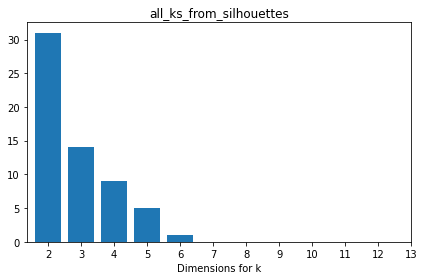

In [17]:
# GENERATE TWO LISTS OF BEST K VALUES USING ELBOW AND SILHOUETTE TECHNIQUES
all_elbows = util.get_elbow_array(h5, all_indices, range(1,14), 'all_elbows', show_plot, 0.25)
all_ks_from_silhouettes = util.get_k_array_from_silhouettes(h5, all_indices, range(2,14), 'all_ks_from_silhouettes', True)

In [18]:
#LOOKS OVER EACH PARTICIPANT'S RATINGS, ASSESSING THE SCORE OF ELBOW AND SILHOUETTE (ARRANGED BY SUBGROUP)
elbow_groups=[]
ks_from_silhouette_groups=[]
indices_groups_list_names = ['sessions_indices_lists', 'singers_indices_lists', 'registers_indices_lists', 'genders_indices_lists']
for grp_idx, group_indices in enumerate(subgroups_indices_list):
    elbow_condition_list = []
    silhouette_condition_list = []
    for con_idx, condition_indices in enumerate(group_indices):
        ks_from_silhouettes = util.get_k_array_from_silhouettes(h5, condition_indices, range(2,14), indices_groups_list_names[grp_idx]+' - Condition '+str(con_idx), show_plot)
        elbows = util.get_elbow_array(h5, condition_indices, range(1,14), indices_groups_list_names[grp_idx]+' - Condition '+str(con_idx), show_plot, 1.0)
        silhouette_condition_list.append(ks_from_silhouettes)
        elbow_condition_list.append(elbows)
    elbow_groups.append(elbow_condition_list)
    ks_from_silhouette_groups.append(silhouette_condition_list)

/Users/brendanoconnor/Desktop/PycharmProjects/Mds4VoiceTimbre/4Github/venvVoicePerception/lib/python3.7/site-packages/scipy/cluster/hierarchy.py:826: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='ward', metric='euclidean')
/Users/brendanoconnor/Desktop/PycharmProjects/Mds4VoiceTimbre/4Github/venvVoicePerception/lib/python3.7/site-packages/scipy/cluster/hierarchy.py:826: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='ward', metric='euclidean')
/Users/brendanoconnor/Desktop/PycharmProjects/Mds4VoiceTimbre/4Github/venvVoicePerception/lib/python3.7/site-packages/scipy/cluster/hierarchy.py:826: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, met

/Users/brendanoconnor/Desktop/PycharmProjects/Mds4VoiceTimbre/4Github/venvVoicePerception/lib/python3.7/site-packages/scipy/cluster/hierarchy.py:826: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='ward', metric='euclidean')
/Users/brendanoconnor/Desktop/PycharmProjects/Mds4VoiceTimbre/4Github/venvVoicePerception/lib/python3.7/site-packages/scipy/cluster/hierarchy.py:826: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='ward', metric='euclidean')
/Users/brendanoconnor/Desktop/PycharmProjects/Mds4VoiceTimbre/4Github/venvVoicePerception/lib/python3.7/site-packages/scipy/cluster/hierarchy.py:826: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, met

/Users/brendanoconnor/Desktop/PycharmProjects/Mds4VoiceTimbre/4Github/venvVoicePerception/lib/python3.7/site-packages/scipy/cluster/hierarchy.py:826: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='ward', metric='euclidean')
/Users/brendanoconnor/Desktop/PycharmProjects/Mds4VoiceTimbre/4Github/venvVoicePerception/lib/python3.7/site-packages/scipy/cluster/hierarchy.py:826: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='ward', metric='euclidean')
/Users/brendanoconnor/Desktop/PycharmProjects/Mds4VoiceTimbre/4Github/venvVoicePerception/lib/python3.7/site-packages/scipy/cluster/hierarchy.py:826: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, met

/Users/brendanoconnor/Desktop/PycharmProjects/Mds4VoiceTimbre/4Github/venvVoicePerception/lib/python3.7/site-packages/scipy/cluster/hierarchy.py:826: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='ward', metric='euclidean')
/Users/brendanoconnor/Desktop/PycharmProjects/Mds4VoiceTimbre/4Github/venvVoicePerception/lib/python3.7/site-packages/scipy/cluster/hierarchy.py:826: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='ward', metric='euclidean')
/Users/brendanoconnor/Desktop/PycharmProjects/Mds4VoiceTimbre/4Github/venvVoicePerception/lib/python3.7/site-packages/scipy/cluster/hierarchy.py:826: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, met

/Users/brendanoconnor/Desktop/PycharmProjects/Mds4VoiceTimbre/4Github/venvVoicePerception/lib/python3.7/site-packages/scipy/cluster/hierarchy.py:826: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='ward', metric='euclidean')
/Users/brendanoconnor/Desktop/PycharmProjects/Mds4VoiceTimbre/4Github/venvVoicePerception/lib/python3.7/site-packages/scipy/cluster/hierarchy.py:826: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='ward', metric='euclidean')
/Users/brendanoconnor/Desktop/PycharmProjects/Mds4VoiceTimbre/4Github/venvVoicePerception/lib/python3.7/site-packages/scipy/cluster/hierarchy.py:826: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, met

/Users/brendanoconnor/Desktop/PycharmProjects/Mds4VoiceTimbre/4Github/venvVoicePerception/lib/python3.7/site-packages/scipy/cluster/hierarchy.py:826: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='ward', metric='euclidean')
/Users/brendanoconnor/Desktop/PycharmProjects/Mds4VoiceTimbre/4Github/venvVoicePerception/lib/python3.7/site-packages/scipy/cluster/hierarchy.py:826: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='ward', metric='euclidean')
/Users/brendanoconnor/Desktop/PycharmProjects/Mds4VoiceTimbre/4Github/venvVoicePerception/lib/python3.7/site-packages/scipy/cluster/hierarchy.py:826: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, met

/Users/brendanoconnor/Desktop/PycharmProjects/Mds4VoiceTimbre/4Github/venvVoicePerception/lib/python3.7/site-packages/scipy/cluster/hierarchy.py:826: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='ward', metric='euclidean')
/Users/brendanoconnor/Desktop/PycharmProjects/Mds4VoiceTimbre/4Github/venvVoicePerception/lib/python3.7/site-packages/scipy/cluster/hierarchy.py:826: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='ward', metric='euclidean')
/Users/brendanoconnor/Desktop/PycharmProjects/Mds4VoiceTimbre/4Github/venvVoicePerception/lib/python3.7/site-packages/scipy/cluster/hierarchy.py:826: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, met

/Users/brendanoconnor/Desktop/PycharmProjects/Mds4VoiceTimbre/4Github/venvVoicePerception/lib/python3.7/site-packages/scipy/cluster/hierarchy.py:826: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='ward', metric='euclidean')
/Users/brendanoconnor/Desktop/PycharmProjects/Mds4VoiceTimbre/4Github/venvVoicePerception/lib/python3.7/site-packages/scipy/cluster/hierarchy.py:826: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='ward', metric='euclidean')
/Users/brendanoconnor/Desktop/PycharmProjects/Mds4VoiceTimbre/4Github/venvVoicePerception/lib/python3.7/site-packages/scipy/cluster/hierarchy.py:826: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, met

/Users/brendanoconnor/Desktop/PycharmProjects/Mds4VoiceTimbre/4Github/venvVoicePerception/lib/python3.7/site-packages/scipy/cluster/hierarchy.py:826: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='ward', metric='euclidean')
/Users/brendanoconnor/Desktop/PycharmProjects/Mds4VoiceTimbre/4Github/venvVoicePerception/lib/python3.7/site-packages/scipy/cluster/hierarchy.py:826: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='ward', metric='euclidean')
/Users/brendanoconnor/Desktop/PycharmProjects/Mds4VoiceTimbre/4Github/venvVoicePerception/lib/python3.7/site-packages/scipy/cluster/hierarchy.py:826: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, met

/Users/brendanoconnor/Desktop/PycharmProjects/Mds4VoiceTimbre/4Github/venvVoicePerception/lib/python3.7/site-packages/scipy/cluster/hierarchy.py:826: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='ward', metric='euclidean')
/Users/brendanoconnor/Desktop/PycharmProjects/Mds4VoiceTimbre/4Github/venvVoicePerception/lib/python3.7/site-packages/scipy/cluster/hierarchy.py:826: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='ward', metric='euclidean')
/Users/brendanoconnor/Desktop/PycharmProjects/Mds4VoiceTimbre/4Github/venvVoicePerception/lib/python3.7/site-packages/scipy/cluster/hierarchy.py:826: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, met

/Users/brendanoconnor/Desktop/PycharmProjects/Mds4VoiceTimbre/4Github/venvVoicePerception/lib/python3.7/site-packages/scipy/cluster/hierarchy.py:826: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='ward', metric='euclidean')
/Users/brendanoconnor/Desktop/PycharmProjects/Mds4VoiceTimbre/4Github/venvVoicePerception/lib/python3.7/site-packages/scipy/cluster/hierarchy.py:826: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='ward', metric='euclidean')
/Users/brendanoconnor/Desktop/PycharmProjects/Mds4VoiceTimbre/4Github/venvVoicePerception/lib/python3.7/site-packages/scipy/cluster/hierarchy.py:826: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, met

/Users/brendanoconnor/Desktop/PycharmProjects/Mds4VoiceTimbre/4Github/venvVoicePerception/lib/python3.7/site-packages/scipy/cluster/hierarchy.py:826: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='ward', metric='euclidean')
/Users/brendanoconnor/Desktop/PycharmProjects/Mds4VoiceTimbre/4Github/venvVoicePerception/lib/python3.7/site-packages/scipy/cluster/hierarchy.py:826: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='ward', metric='euclidean')
/Users/brendanoconnor/Desktop/PycharmProjects/Mds4VoiceTimbre/4Github/venvVoicePerception/lib/python3.7/site-packages/scipy/cluster/hierarchy.py:826: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, met

/Users/brendanoconnor/Desktop/PycharmProjects/Mds4VoiceTimbre/4Github/venvVoicePerception/lib/python3.7/site-packages/scipy/cluster/hierarchy.py:826: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='ward', metric='euclidean')
/Users/brendanoconnor/Desktop/PycharmProjects/Mds4VoiceTimbre/4Github/venvVoicePerception/lib/python3.7/site-packages/scipy/cluster/hierarchy.py:826: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='ward', metric='euclidean')
/Users/brendanoconnor/Desktop/PycharmProjects/Mds4VoiceTimbre/4Github/venvVoicePerception/lib/python3.7/site-packages/scipy/cluster/hierarchy.py:826: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, met

/Users/brendanoconnor/Desktop/PycharmProjects/Mds4VoiceTimbre/4Github/venvVoicePerception/lib/python3.7/site-packages/scipy/cluster/hierarchy.py:826: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='ward', metric='euclidean')
/Users/brendanoconnor/Desktop/PycharmProjects/Mds4VoiceTimbre/4Github/venvVoicePerception/lib/python3.7/site-packages/scipy/cluster/hierarchy.py:826: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='ward', metric='euclidean')
/Users/brendanoconnor/Desktop/PycharmProjects/Mds4VoiceTimbre/4Github/venvVoicePerception/lib/python3.7/site-packages/scipy/cluster/hierarchy.py:826: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, met

/Users/brendanoconnor/Desktop/PycharmProjects/Mds4VoiceTimbre/4Github/venvVoicePerception/lib/python3.7/site-packages/scipy/cluster/hierarchy.py:826: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='ward', metric='euclidean')
/Users/brendanoconnor/Desktop/PycharmProjects/Mds4VoiceTimbre/4Github/venvVoicePerception/lib/python3.7/site-packages/scipy/cluster/hierarchy.py:826: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='ward', metric='euclidean')
/Users/brendanoconnor/Desktop/PycharmProjects/Mds4VoiceTimbre/4Github/venvVoicePerception/lib/python3.7/site-packages/scipy/cluster/hierarchy.py:826: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, met

/Users/brendanoconnor/Desktop/PycharmProjects/Mds4VoiceTimbre/4Github/venvVoicePerception/lib/python3.7/site-packages/scipy/cluster/hierarchy.py:826: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='ward', metric='euclidean')
/Users/brendanoconnor/Desktop/PycharmProjects/Mds4VoiceTimbre/4Github/venvVoicePerception/lib/python3.7/site-packages/scipy/cluster/hierarchy.py:826: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='ward', metric='euclidean')
/Users/brendanoconnor/Desktop/PycharmProjects/Mds4VoiceTimbre/4Github/venvVoicePerception/lib/python3.7/site-packages/scipy/cluster/hierarchy.py:826: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, met

/Users/brendanoconnor/Desktop/PycharmProjects/Mds4VoiceTimbre/4Github/venvVoicePerception/lib/python3.7/site-packages/scipy/cluster/hierarchy.py:826: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='ward', metric='euclidean')
/Users/brendanoconnor/Desktop/PycharmProjects/Mds4VoiceTimbre/4Github/venvVoicePerception/lib/python3.7/site-packages/scipy/cluster/hierarchy.py:826: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='ward', metric='euclidean')
/Users/brendanoconnor/Desktop/PycharmProjects/Mds4VoiceTimbre/4Github/venvVoicePerception/lib/python3.7/site-packages/scipy/cluster/hierarchy.py:826: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, met

/Users/brendanoconnor/Desktop/PycharmProjects/Mds4VoiceTimbre/4Github/venvVoicePerception/lib/python3.7/site-packages/scipy/cluster/hierarchy.py:826: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='ward', metric='euclidean')
/Users/brendanoconnor/Desktop/PycharmProjects/Mds4VoiceTimbre/4Github/venvVoicePerception/lib/python3.7/site-packages/scipy/cluster/hierarchy.py:826: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='ward', metric='euclidean')
/Users/brendanoconnor/Desktop/PycharmProjects/Mds4VoiceTimbre/4Github/venvVoicePerception/lib/python3.7/site-packages/scipy/cluster/hierarchy.py:826: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, met

/Users/brendanoconnor/Desktop/PycharmProjects/Mds4VoiceTimbre/4Github/venvVoicePerception/lib/python3.7/site-packages/scipy/cluster/hierarchy.py:826: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='ward', metric='euclidean')
/Users/brendanoconnor/Desktop/PycharmProjects/Mds4VoiceTimbre/4Github/venvVoicePerception/lib/python3.7/site-packages/scipy/cluster/hierarchy.py:826: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='ward', metric='euclidean')
/Users/brendanoconnor/Desktop/PycharmProjects/Mds4VoiceTimbre/4Github/venvVoicePerception/lib/python3.7/site-packages/scipy/cluster/hierarchy.py:826: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, met

/Users/brendanoconnor/Desktop/PycharmProjects/Mds4VoiceTimbre/4Github/venvVoicePerception/lib/python3.7/site-packages/scipy/cluster/hierarchy.py:826: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='ward', metric='euclidean')
/Users/brendanoconnor/Desktop/PycharmProjects/Mds4VoiceTimbre/4Github/venvVoicePerception/lib/python3.7/site-packages/scipy/cluster/hierarchy.py:826: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='ward', metric='euclidean')
/Users/brendanoconnor/Desktop/PycharmProjects/Mds4VoiceTimbre/4Github/venvVoicePerception/lib/python3.7/site-packages/scipy/cluster/hierarchy.py:826: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, met

/Users/brendanoconnor/Desktop/PycharmProjects/Mds4VoiceTimbre/4Github/venvVoicePerception/lib/python3.7/site-packages/scipy/cluster/hierarchy.py:826: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='ward', metric='euclidean')
/Users/brendanoconnor/Desktop/PycharmProjects/Mds4VoiceTimbre/4Github/venvVoicePerception/lib/python3.7/site-packages/scipy/cluster/hierarchy.py:826: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='ward', metric='euclidean')
/Users/brendanoconnor/Desktop/PycharmProjects/Mds4VoiceTimbre/4Github/venvVoicePerception/lib/python3.7/site-packages/scipy/cluster/hierarchy.py:826: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, met

/Users/brendanoconnor/Desktop/PycharmProjects/Mds4VoiceTimbre/4Github/venvVoicePerception/lib/python3.7/site-packages/scipy/cluster/hierarchy.py:826: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='ward', metric='euclidean')
/Users/brendanoconnor/Desktop/PycharmProjects/Mds4VoiceTimbre/4Github/venvVoicePerception/lib/python3.7/site-packages/scipy/cluster/hierarchy.py:826: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='ward', metric='euclidean')
/Users/brendanoconnor/Desktop/PycharmProjects/Mds4VoiceTimbre/4Github/venvVoicePerception/lib/python3.7/site-packages/scipy/cluster/hierarchy.py:826: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, met

/Users/brendanoconnor/Desktop/PycharmProjects/Mds4VoiceTimbre/4Github/venvVoicePerception/lib/python3.7/site-packages/scipy/cluster/hierarchy.py:826: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='ward', metric='euclidean')
/Users/brendanoconnor/Desktop/PycharmProjects/Mds4VoiceTimbre/4Github/venvVoicePerception/lib/python3.7/site-packages/scipy/cluster/hierarchy.py:826: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='ward', metric='euclidean')
/Users/brendanoconnor/Desktop/PycharmProjects/Mds4VoiceTimbre/4Github/venvVoicePerception/lib/python3.7/site-packages/scipy/cluster/hierarchy.py:826: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, met

/Users/brendanoconnor/Desktop/PycharmProjects/Mds4VoiceTimbre/4Github/venvVoicePerception/lib/python3.7/site-packages/scipy/cluster/hierarchy.py:826: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='ward', metric='euclidean')
/Users/brendanoconnor/Desktop/PycharmProjects/Mds4VoiceTimbre/4Github/venvVoicePerception/lib/python3.7/site-packages/scipy/cluster/hierarchy.py:826: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='ward', metric='euclidean')
/Users/brendanoconnor/Desktop/PycharmProjects/Mds4VoiceTimbre/4Github/venvVoicePerception/lib/python3.7/site-packages/scipy/cluster/hierarchy.py:826: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, met

/Users/brendanoconnor/Desktop/PycharmProjects/Mds4VoiceTimbre/4Github/venvVoicePerception/lib/python3.7/site-packages/scipy/cluster/hierarchy.py:826: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='ward', metric='euclidean')
/Users/brendanoconnor/Desktop/PycharmProjects/Mds4VoiceTimbre/4Github/venvVoicePerception/lib/python3.7/site-packages/scipy/cluster/hierarchy.py:826: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='ward', metric='euclidean')
/Users/brendanoconnor/Desktop/PycharmProjects/Mds4VoiceTimbre/4Github/venvVoicePerception/lib/python3.7/site-packages/scipy/cluster/hierarchy.py:826: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, met

/Users/brendanoconnor/Desktop/PycharmProjects/Mds4VoiceTimbre/4Github/venvVoicePerception/lib/python3.7/site-packages/scipy/cluster/hierarchy.py:826: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='ward', metric='euclidean')
/Users/brendanoconnor/Desktop/PycharmProjects/Mds4VoiceTimbre/4Github/venvVoicePerception/lib/python3.7/site-packages/scipy/cluster/hierarchy.py:826: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='ward', metric='euclidean')
/Users/brendanoconnor/Desktop/PycharmProjects/Mds4VoiceTimbre/4Github/venvVoicePerception/lib/python3.7/site-packages/scipy/cluster/hierarchy.py:826: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, met

/Users/brendanoconnor/Desktop/PycharmProjects/Mds4VoiceTimbre/4Github/venvVoicePerception/lib/python3.7/site-packages/scipy/cluster/hierarchy.py:826: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='ward', metric='euclidean')
/Users/brendanoconnor/Desktop/PycharmProjects/Mds4VoiceTimbre/4Github/venvVoicePerception/lib/python3.7/site-packages/scipy/cluster/hierarchy.py:826: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='ward', metric='euclidean')
/Users/brendanoconnor/Desktop/PycharmProjects/Mds4VoiceTimbre/4Github/venvVoicePerception/lib/python3.7/site-packages/scipy/cluster/hierarchy.py:826: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, met

/Users/brendanoconnor/Desktop/PycharmProjects/Mds4VoiceTimbre/4Github/venvVoicePerception/lib/python3.7/site-packages/scipy/cluster/hierarchy.py:826: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='ward', metric='euclidean')
/Users/brendanoconnor/Desktop/PycharmProjects/Mds4VoiceTimbre/4Github/venvVoicePerception/lib/python3.7/site-packages/scipy/cluster/hierarchy.py:826: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='ward', metric='euclidean')
/Users/brendanoconnor/Desktop/PycharmProjects/Mds4VoiceTimbre/4Github/venvVoicePerception/lib/python3.7/site-packages/scipy/cluster/hierarchy.py:826: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, met

/Users/brendanoconnor/Desktop/PycharmProjects/Mds4VoiceTimbre/4Github/venvVoicePerception/lib/python3.7/site-packages/scipy/cluster/hierarchy.py:826: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='ward', metric='euclidean')
/Users/brendanoconnor/Desktop/PycharmProjects/Mds4VoiceTimbre/4Github/venvVoicePerception/lib/python3.7/site-packages/scipy/cluster/hierarchy.py:826: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='ward', metric='euclidean')
/Users/brendanoconnor/Desktop/PycharmProjects/Mds4VoiceTimbre/4Github/venvVoicePerception/lib/python3.7/site-packages/scipy/cluster/hierarchy.py:826: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, met

/Users/brendanoconnor/Desktop/PycharmProjects/Mds4VoiceTimbre/4Github/venvVoicePerception/lib/python3.7/site-packages/scipy/cluster/hierarchy.py:826: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='ward', metric='euclidean')
/Users/brendanoconnor/Desktop/PycharmProjects/Mds4VoiceTimbre/4Github/venvVoicePerception/lib/python3.7/site-packages/scipy/cluster/hierarchy.py:826: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='ward', metric='euclidean')
/Users/brendanoconnor/Desktop/PycharmProjects/Mds4VoiceTimbre/4Github/venvVoicePerception/lib/python3.7/site-packages/scipy/cluster/hierarchy.py:826: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, met

In [20]:
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import adjusted_rand_score, silhouette_score

# LOOKS OVER EACH PARTICIPANT AND GENERATES METRIC SCORES FOR THEIR CLUSTERING BEHAVIOUR
cluster_perf_2 = np.empty((0,6))
cluster_perf_5 = np.empty((0,6))
for idx in range(num_experiments):
    for best_num_clusters in [2,5]:
    #    print(idx, h5['participantInfo'][idx])
        rearranged_dissim_matrix = h5['rearrangedDissimMatrix'][idx]
        rearranged_ref_audio = h5['rearrangedReferenceAudioNames'][idx]
        rearranged_class_list = util.strings_to_classes(rearranged_ref_audio, label_list)
    #    dissim_matrix = np.around(rearranged_dissim_matrix, 2)
        if show_plot == True:
            util.display_dissim_heatmaps(rearranged_dissim_matrix, rearranged_ref_audio)
        util.mds_from_dissim_matrix(rearranged_dissim_matrix, rearranged_ref_audio, 3, show_plot=show_plot)
        # CLUSTER
        # dendrogram = sch.dendrogram(sch.linkage(rearranged_dissim_matrix, method='ward'))
        hc = AgglomerativeClustering(n_clusters=best_num_clusters, affinity = 'euclidean', linkage='ward')
        hc_clustering = hc.fit_predict(rearranged_dissim_matrix)
        # the silhouette score is higher when clusters are dense - bounded between -1 for incorrect clustering and
        # 1 for dense clustering. Around zero when clusters are overlapping
        hc_sil_score = silhouette_score(rearranged_dissim_matrix, hc_clustering, metric='euclidean')   
        km = KMeans(n_clusters=best_num_clusters)
        km.fit_predict(rearranged_dissim_matrix)
        sse = km.inertia_
        kmeans_refs_and_clusters = util.assign_clusters(rearranged_dissim_matrix, rearranged_ref_audio, best_num_clusters)
        kmeans_cluster_list = kmeans_refs_and_clusters[:,1].tolist()
        kmeans_cluster_accuracy = adjusted_rand_score(kmeans_cluster_list, rearranged_class_list)
        hc_cluster_accuracy = adjusted_rand_score(hc_clustering, rearranged_class_list)
        kmeans_hc_accuracy_comparison = adjusted_rand_score(hc_clustering, kmeans_cluster_list)
        if best_num_clusters == 2:
            cluster_perf_2 = np.append(cluster_perf_2, np.array([[idx, sse, kmeans_cluster_accuracy,
                                               hc_cluster_accuracy, hc_sil_score, kmeans_hc_accuracy_comparison]]), axis=0)
        else:
            cluster_perf_5 = np.append(cluster_perf_5, np.array([[idx, sse, kmeans_cluster_accuracy,
                                               hc_cluster_accuracy, hc_sil_score, kmeans_hc_accuracy_comparison]]), axis=0)

/Users/brendanoconnor/Desktop/PycharmProjects/Mds4VoiceTimbre/4Github/venvVoicePerception/lib/python3.7/site-packages/scipy/cluster/hierarchy.py:826: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='ward', metric='euclidean')
/Users/brendanoconnor/Desktop/PycharmProjects/Mds4VoiceTimbre/4Github/venvVoicePerception/lib/python3.7/site-packages/scipy/cluster/hierarchy.py:826: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='ward', metric='euclidean')
/Users/brendanoconnor/Desktop/PycharmProjects/Mds4VoiceTimbre/4Github/venvVoicePerception/lib/python3.7/site-packages/scipy/cluster/hierarchy.py:826: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, met

/Users/brendanoconnor/Desktop/PycharmProjects/Mds4VoiceTimbre/4Github/venvVoicePerception/lib/python3.7/site-packages/scipy/cluster/hierarchy.py:826: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='ward', metric='euclidean')
/Users/brendanoconnor/Desktop/PycharmProjects/Mds4VoiceTimbre/4Github/venvVoicePerception/lib/python3.7/site-packages/scipy/cluster/hierarchy.py:826: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='ward', metric='euclidean')
/Users/brendanoconnor/Desktop/PycharmProjects/Mds4VoiceTimbre/4Github/venvVoicePerception/lib/python3.7/site-packages/scipy/cluster/hierarchy.py:826: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, met

/Users/brendanoconnor/Desktop/PycharmProjects/Mds4VoiceTimbre/4Github/venvVoicePerception/lib/python3.7/site-packages/scipy/cluster/hierarchy.py:826: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='ward', metric='euclidean')
/Users/brendanoconnor/Desktop/PycharmProjects/Mds4VoiceTimbre/4Github/venvVoicePerception/lib/python3.7/site-packages/scipy/cluster/hierarchy.py:826: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='ward', metric='euclidean')
/Users/brendanoconnor/Desktop/PycharmProjects/Mds4VoiceTimbre/4Github/venvVoicePerception/lib/python3.7/site-packages/scipy/cluster/hierarchy.py:826: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, met

/Users/brendanoconnor/Desktop/PycharmProjects/Mds4VoiceTimbre/4Github/venvVoicePerception/lib/python3.7/site-packages/scipy/cluster/hierarchy.py:826: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='ward', metric='euclidean')
/Users/brendanoconnor/Desktop/PycharmProjects/Mds4VoiceTimbre/4Github/venvVoicePerception/lib/python3.7/site-packages/scipy/cluster/hierarchy.py:826: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='ward', metric='euclidean')
/Users/brendanoconnor/Desktop/PycharmProjects/Mds4VoiceTimbre/4Github/venvVoicePerception/lib/python3.7/site-packages/scipy/cluster/hierarchy.py:826: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, met

/Users/brendanoconnor/Desktop/PycharmProjects/Mds4VoiceTimbre/4Github/venvVoicePerception/lib/python3.7/site-packages/scipy/cluster/hierarchy.py:826: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='ward', metric='euclidean')
/Users/brendanoconnor/Desktop/PycharmProjects/Mds4VoiceTimbre/4Github/venvVoicePerception/lib/python3.7/site-packages/scipy/cluster/hierarchy.py:826: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='ward', metric='euclidean')
/Users/brendanoconnor/Desktop/PycharmProjects/Mds4VoiceTimbre/4Github/venvVoicePerception/lib/python3.7/site-packages/scipy/cluster/hierarchy.py:826: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, met

In [24]:
import pandas as pd

# CHECH FOR OUTLIERS AMONG PARTICIPANTS' DISSIMILARITY MATRICES
# It can be observed from that the distribution between clusters in hc_new_clustering is fairly even, and therefore no datasets are considered outliers
flattened_matrices = np.empty((0,225))
for idx in range(num_experiments):
    rearranged_dissim_matrix = h5['dissimMatrix15Dims'][idx]
    flattened_dissim_matrix = rearranged_dissim_matrix.flatten()
    flattened_dissim_matrix = flattened_dissim_matrix.reshape(-1, len(flattened_dissim_matrix))
    flattened_matrices = np.append(flattened_matrices,flattened_dissim_matrix, axis=0)
#convert to pandas dataframe
df = pd.DataFrame(flattened_matrices)
# swap axes
df_tran = df.T
# generate coorelation matrix for all columns
df_tran_corr = df_tran.corr('spearman')
if show_plot==True:
    sns.heatmap(df_tran_corr, cmap = "RdBu")
# perform hc clustering to find outlier clusters that are behaving abnormally
hcs = []
for i in range(1,10):
    new_hc = AgglomerativeClustering(n_clusters=i, affinity = 'euclidean', linkage='ward')
    hc_new_clustering = new_hc.fit_predict(df_tran_corr)
    print('For {0} clusters, the data splits in the following way:'.format(i))
    print(hc_new_clustering)
    hcs.append(hc_new_clustering)

For 1 clusters, the data splits in the following way:
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
For 2 clusters, the data splits in the following way:
[0 1 1 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 1 1 1 0 1 0 1 0 0 1 0 1 0 0 0 0 1 0
 0 0 1 1 1 1 1 0 0 0 0 0 1 0 0 0 1 0 1 0 1 1 0]
For 3 clusters, the data splits in the following way:
[2 0 0 2 0 0 0 0 0 0 1 1 2 1 2 2 2 2 1 0 0 0 2 0 1 0 1 1 0 2 0 1 1 2 2 0 2
 1 2 0 0 0 0 0 1 2 2 2 2 0 1 2 1 0 2 0 2 0 0 1]
For 4 clusters, the data splits in the following way:
[2 3 3 2 3 1 3 1 1 1 0 0 2 0 2 2 2 2 0 1 1 3 2 1 0 1 0 0 1 2 1 0 0 2 2 1 2
 0 2 3 1 1 3 1 0 2 2 2 2 1 0 2 0 3 2 1 2 1 1 0]
For 5 clusters, the data splits in the following way:
[2 3 3 2 3 0 3 0 0 0 1 4 2 1 2 2 2 2 4 0 0 3 2 0 4 0 4 1 0 2 0 1 4 2 2 0 2
 1 2 3 0 0 3 0 1 2 2 2 2 0 1 2 1 3 2 0 2 0 0 1]
For 6 clusters, the data splits in the following way:
[0 3 3 0 3 5 3 2 5 5 1 4 0 1 0 0 0 0 4 5 2 3 0 2 4 2 4 1 5 0 

In [25]:
#REFORMAT GROUPINGS OF LISTS FOR STATISTICAL TESTS

num_variables = len(cluster_perf_2[0])
cluster2_scores_list = []
for conditions_indices_list in subgroups_indices_list:
    variables_list = []
    for variable_col in range(1, num_variables):
        values_list = []
        for idx in conditions_indices_list:
            values_list.append(cluster_perf_2[idx,variable_col])
        variables_list.append(values_list)
    cluster2_scores_list.append(variables_list)
    
cluster5_scores_list = []
for conditions_indices_list in subgroups_indices_list:
    variables_list = []
    for variable_col in range(1, num_variables):
        values_list = []
        for idx in conditions_indices_list:
            values_list.append(cluster_perf_5[idx,variable_col])
        variables_list.append(values_list)
    cluster5_scores_list.append(variables_list)

# Statistical Analysis

In [27]:
# GENERATE NUMPY WITH CLUSTERING AND PROFILE METRICS
profile_clustering_measures = np.concatenate((profile_array, cluster_perf_5), axis=1)

#REMOVE ALL UNNECESSARY FEATURES/METRICS
profile_clustering_measures_reduced = np.delete(profile_clustering_measures, 13, 1) # delete hc vrs kmeans solution similarity
profile_clustering_measures_reduced = np.delete(profile_clustering_measures_reduced, 10, 1) # delete kmeans acc as we're using hc accuracy
profile_clustering_measures_reduced = np.delete(profile_clustering_measures_reduced, 8, 1) # delete indices column that came from cluster_perf_5
profile_clustering_measures_reduced = np.delete(profile_clustering_measures_reduced, 0, 1) # delete indices column that came from profile_array

# CREATE VERSION OF CLUSTER-PROFILE FEATURES WHERE PARTICIPANTS WITH INCONCLUSIVE FEEDBACK (VALUE=5) ARE REMOVED
no_task_feedback_indices = np.where(profile_clustering_measures_reduced[:,4]==5)[0]
no_task_feedback_indices[::-1].sort() # reverses the numpy
profile_clustering_measures_reduced_shortened = profile_clustering_measures_reduced.copy()
for i in no_task_feedback_indices:
    profile_clustering_measures_reduced_shortened = np.delete(profile_clustering_measures_reduced_shortened, i, 0)

### CORRELATION BETWEEN CLUSTER AND PROFILE METRICS

In [29]:
# only consider entries from coorelation_sig_array (metric_a, metric_b, r_value, p_value) that are ordinal-based data
correlation_array, correlation_sig_array = util.array_column_correlations(profile_clustering_measures_reduced, 0.05, 'spearmanr', show_plots=False)
correlation_sig_array

Correlations: p<0.05


array([[ 2.00000000e+00,  3.00000000e+00,  3.08391989e-01,
         1.65167126e-02],
       [ 2.00000000e+00,  7.00000000e+00, -3.74060099e-01,
         3.23792147e-03],
       [ 2.00000000e+00,  8.00000000e+00,  4.47980273e-01,
         3.31636829e-04],
       [ 2.00000000e+00,  9.00000000e+00,  3.03736267e-01,
         1.83107347e-02],
       [ 3.00000000e+00,  2.00000000e+00,  3.08391989e-01,
         1.65167126e-02],
       [ 3.00000000e+00,  7.00000000e+00, -2.99321790e-01,
         2.01626419e-02],
       [ 3.00000000e+00,  9.00000000e+00,  2.80474151e-01,
         2.99602788e-02],
       [ 6.00000000e+00,  7.00000000e+00,  5.96276744e-01,
         4.97959878e-07],
       [ 7.00000000e+00,  2.00000000e+00, -3.74060099e-01,
         3.23792147e-03],
       [ 7.00000000e+00,  3.00000000e+00, -2.99321790e-01,
         2.01626419e-02],
       [ 7.00000000e+00,  6.00000000e+00,  5.96276744e-01,
         4.97959878e-07],
       [ 7.00000000e+00,  8.00000000e+00, -2.95661136e-01,
      

In [30]:
correlation_array, correlation_sig_array = util.array_column_correlations(profile_clustering_measures_reduced_shortened, 0.05, 'spearmanr', show_plots=False)
correlation_sig_array

Correlations: p<0.05


array([[ 2.00000000e+00,  3.00000000e+00,  4.04088149e-01,
         1.31231173e-02],
       [ 2.00000000e+00,  4.00000000e+00,  4.00650573e-01,
         1.39971722e-02],
       [ 2.00000000e+00,  7.00000000e+00, -4.30656653e-01,
         7.79595471e-03],
       [ 2.00000000e+00,  8.00000000e+00,  4.47770343e-01,
         5.45265013e-03],
       [ 2.00000000e+00,  9.00000000e+00,  4.12581124e-01,
         1.11592858e-02],
       [ 3.00000000e+00,  2.00000000e+00,  4.04088149e-01,
         1.31231173e-02],
       [ 3.00000000e+00,  9.00000000e+00,  3.94611500e-01,
         1.56517109e-02],
       [ 4.00000000e+00,  2.00000000e+00,  4.00650573e-01,
         1.39971722e-02],
       [ 4.00000000e+00,  7.00000000e+00, -3.25930692e-01,
         4.89943051e-02],
       [ 4.00000000e+00,  8.00000000e+00,  5.28329581e-01,
         7.76127178e-04],
       [ 6.00000000e+00,  7.00000000e+00,  5.87482219e-01,
         1.31948107e-04],
       [ 7.00000000e+00,  2.00000000e+00, -4.30656653e-01,
      

In [31]:
# only consider entries from coorelation_sig_array (metric_a, metric_b, r_value, p_value) that are interval-based data
correlation_array, correlation_sig_array = util.array_column_correlations(profile_clustering_measures_reduced, 0.05, 'pearsonr', show_plots=False)
correlation_sig_array

Correlations: p<0.05


array([[ 2.00000000e+00,  3.00000000e+00,  3.01475668e-01,
         1.92401013e-02],
       [ 2.00000000e+00,  7.00000000e+00, -3.64372988e-01,
         4.20769930e-03],
       [ 2.00000000e+00,  8.00000000e+00,  4.63594572e-01,
         1.91142544e-04],
       [ 2.00000000e+00,  9.00000000e+00,  3.29139637e-01,
         1.02329557e-02],
       [ 3.00000000e+00,  2.00000000e+00,  3.01475668e-01,
         1.92401013e-02],
       [ 3.00000000e+00,  7.00000000e+00, -2.91910843e-01,
         2.36292891e-02],
       [ 3.00000000e+00,  9.00000000e+00,  2.69649575e-01,
         3.72035342e-02],
       [ 5.00000000e+00,  6.00000000e+00,  3.01383462e-01,
         1.92788455e-02],
       [ 6.00000000e+00,  5.00000000e+00,  3.01383462e-01,
         1.92788455e-02],
       [ 6.00000000e+00,  7.00000000e+00,  5.69978659e-01,
         1.99834636e-06],
       [ 6.00000000e+00,  9.00000000e+00, -2.58431168e-01,
         4.61850378e-02],
       [ 7.00000000e+00,  2.00000000e+00, -3.64372988e-01,
      

### TEST FOR DIFFERENCE BETWEEN NONPARAMETRIC DISTRIBUTIONS

In [34]:
sig_thresh = 0.05
two_tailed_sig_thresh = sig_thresh/2
# reports differences between conditions for cluster metrics, class-pair distances
annotated_results, results = util.nonpara_multiple_variables_test(cluster2_scores_list, two_tailed_sig_thresh)

sample_a_size, sample_b_size 10 10
variables_group_idx:  1 conditions_group_idx:  1 condition_causing_increase:  (0, 0.14940674532191123) condition_causing_decrease:  (1, 0.04454291971952377) Mean increase:  0.1 Effect size:  -0.29859193367728953 u-value:  10.5 z value:  2.9859 actual_p_val:  0.0014 p value thresh:  0.005
sample_a_size, sample_b_size 10 10
variables_group_idx:  1 conditions_group_idx:  1 condition_causing_increase:  (2, 0.20752394247876005) condition_causing_decrease:  (1, 0.04454291971952377) Mean increase:  0.16 Effect size:  -0.3363883809782122 u-value:  5.5 z value:  3.3639 actual_p_val:  0.0004 p value thresh:  0.005
sample_a_size, sample_b_size 10 10
variables_group_idx:  1 conditions_group_idx:  2 condition_causing_increase:  (0, 0.15788371673091245) condition_causing_decrease:  (1, 0.011926085219053107) Mean increase:  0.15 Effect size:  -0.30615122313747406 u-value:  9.5 z value:  3.0615 actual_p_val:  0.0011 p value thresh:  0.005
sample_a_size, sample_b_size

In [35]:
annotated_results, results = util.nonpara_multiple_variables_test(cluster5_scores_list, two_tailed_sig_thresh)

sample_a_size, sample_b_size 10 10
variables_group_idx:  1 conditions_group_idx:  1 condition_causing_increase:  (0, 0.6135141634424808) condition_causing_decrease:  (1, 0.10100830891873262) Mean increase:  0.51 Effect size:  -0.3401680257083045 u-value:  5.0 z value:  3.4017 actual_p_val:  0.0003 p value thresh:  0.005
sample_a_size, sample_b_size 10 10
variables_group_idx:  1 conditions_group_idx:  1 condition_causing_increase:  (0, 0.6135141634424808) condition_causing_decrease:  (4, 0.21908498583248698) Mean increase:  0.39 Effect size:  -0.3023715784073818 u-value:  10.0 z value:  3.0237 actual_p_val:  0.0012 p value thresh:  0.005
sample_a_size, sample_b_size 10 10
variables_group_idx:  1 conditions_group_idx:  1 condition_causing_increase:  (0, 0.6135141634424808) condition_causing_decrease:  (5, 0.29433714060473604) Mean increase:  0.32 Effect size:  -0.3023715784073818 u-value:  10.0 z value:  3.0237 actual_p_val:  0.0012 p value thresh:  0.005
sample_a_size, sample_b_size 10 

In [36]:
annotated_results, results = util.nonpara_multiple_variables_test(averaged_groups, two_tailed_sig_thresh)

sample_a_size, sample_b_size 10 10
variables_group_idx:  1 conditions_group_idx:  0 condition_causing_increase:  (0, 0.6004444444444444) condition_causing_decrease:  (2, 0.2807222222222222) Mean increase:  0.32 Effect size:  -0.33260873624811993 u-value:  6.0 z value:  3.3261 actual_p_val:  0.0004 p value thresh:  0.005
sample_a_size, sample_b_size 10 10
variables_group_idx:  1 conditions_group_idx:  0 condition_causing_increase:  (1, 0.5640000000000001) condition_causing_decrease:  (2, 0.2807222222222222) Mean increase:  0.28 Effect size:  -0.29481228894719724 u-value:  11.0 z value:  2.9481 actual_p_val:  0.0016 p value thresh:  0.005
sample_a_size, sample_b_size 10 10
variables_group_idx:  1 conditions_group_idx:  0 condition_causing_increase:  (3, 0.5517777777777779) condition_causing_decrease:  (2, 0.2807222222222222) Mean increase:  0.27 Effect size:  -0.29481228894719724 u-value:  11.0 z value:  2.9481 actual_p_val:  0.0016 p value thresh:  0.005
sample_a_size, sample_b_size 10 

/Users/brendanoconnor/Desktop/PycharmProjects/Mds4VoiceTimbre/4Github/util.py:1020: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  'p value thresh:17 ', round(sig_thresh, 4)])


# Generate MDS plots

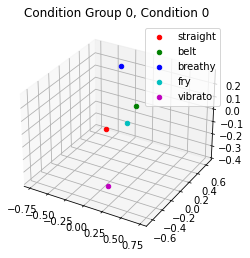

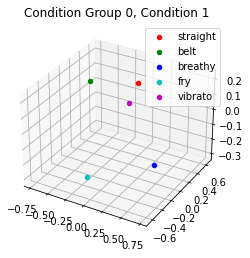

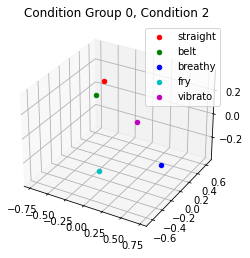

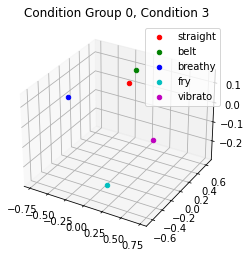

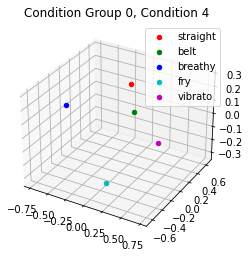

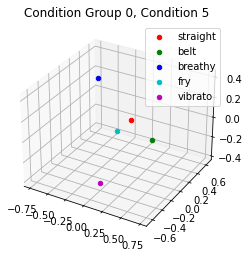

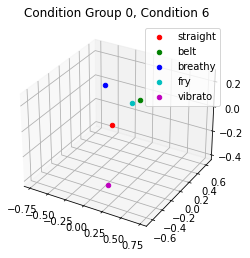

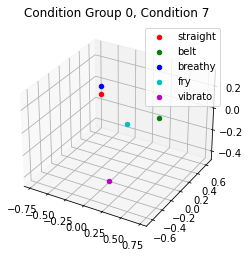

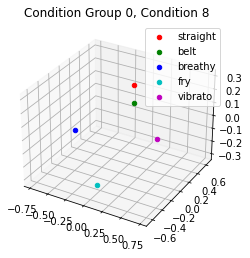

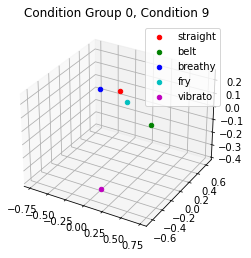

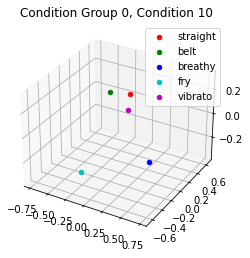

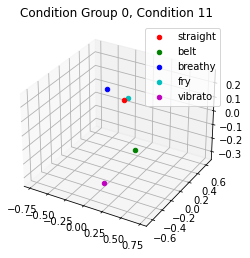

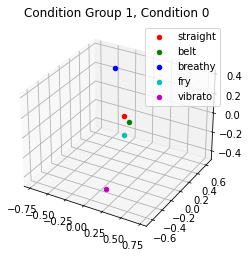

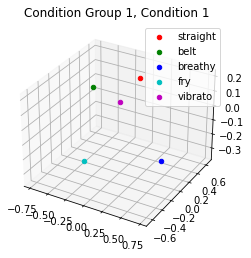

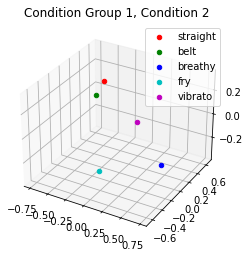

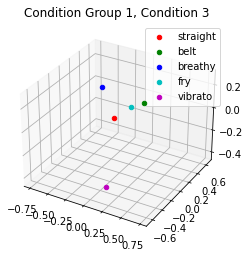

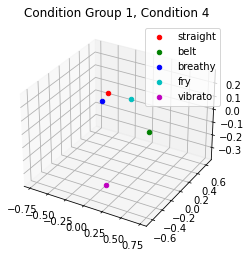

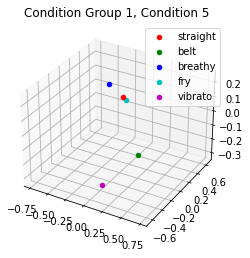

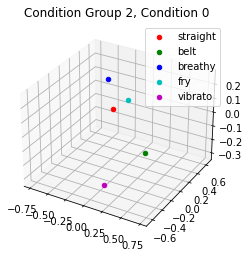

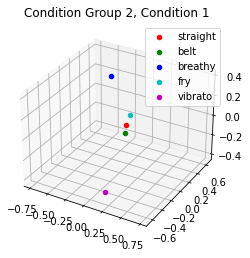

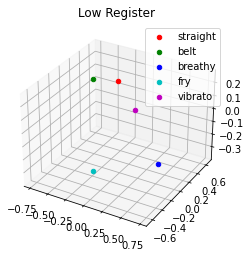

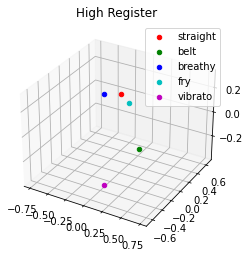

In [24]:
mds_dim = 3

group_names=['Session','Singer','Reg+gen','Register','Gender']
#variables group is itself one of the condition groups that contain variables
for group_idx, variables_group in enumerate(averaged_groups):
    varialble_specific_conditions_group = []
    for variable_idx, conditions_group in enumerate(variables_group):
        # looking at all the values for this group
        condition_specific_value_avgs_group = []
        for values_group in conditions_group:
            value_sum = 0
            for val_idx, value in enumerate(values_group):
                value_sum += value
            value_avg = value_sum/(val_idx+1)
            condition_specific_value_avgs_group.append(value_avg)
        varialble_specific_conditions_group.append(condition_specific_value_avgs_group)
    
    varialble_specific_conditions_group_array = np.asarray(varialble_specific_conditions_group)
    male_class_dissim_avgs = varialble_specific_conditions_group_array[:,0]
    female_class_dissim_avgs = varialble_specific_conditions_group_array[:,1]
    # fill class*class dissim matrix with averages
        
    
    # how many columns are in the array? Thats how many conditions there are
    for condition_int in range(varialble_specific_conditions_group_array.shape[1]):
        class_dissim_matrix = np.empty((5,5))
        conditioned_variables_array = varialble_specific_conditions_group_array[:,condition_int]
        # this will always be the correct order for every class-distance matrix
        class_dissim_matrix[0,1] = conditioned_variables_array[0]
        class_dissim_matrix[0,2] = conditioned_variables_array[1]
        class_dissim_matrix[0,3] = conditioned_variables_array[2]
        class_dissim_matrix[0,4] = conditioned_variables_array[3]
        class_dissim_matrix[1,2] = conditioned_variables_array[4]
        class_dissim_matrix[1,3] = conditioned_variables_array[5]
        class_dissim_matrix[1,4] = conditioned_variables_array[6]
        class_dissim_matrix[2,3] = conditioned_variables_array[7]
        class_dissim_matrix[2,4] = conditioned_variables_array[8]
        class_dissim_matrix[3,4] = conditioned_variables_array[9]
        class_dissim_matrix[0,0] = conditioned_variables_array[10]
        class_dissim_matrix[1,1] = conditioned_variables_array[11]    
        class_dissim_matrix[2,2] = conditioned_variables_array[12]
        class_dissim_matrix[3,3] = conditioned_variables_array[13]
        class_dissim_matrix[4,4] = conditioned_variables_array[14]
        
        for i in range(5):
            for j in range(5):
                class_dissim_matrix[j,i] = class_dissim_matrix[i,j]
        if group_idx==4:
            if condition_int==0:
                title = 'Male'
            else:
                title = 'Female'
        elif group_idx==3:
            if condition_int==0:
                title = 'Low Register'
            else:
                title = 'High Register'
        else:
            title = 'Condition Group ' +str(group_idx) +', Condition ' +str(condition_int)
        util.mds_from_dissim_matrix(class_dissim_matrix, label_list, 3, show_plot=True, title=title)

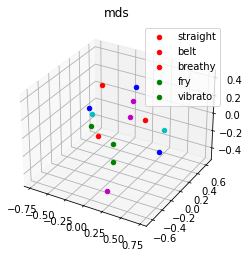

array([[-0.21907797, -0.03629087,  0.4178684 ],
       [ 0.12841307,  0.33937336, -0.0592631 ],
       [ 0.04809534, -0.51097958,  0.13683144],
       [-0.13481155,  0.05980987, -0.47562589],
       [-0.39836765,  0.00475813, -0.09996269],
       [-0.02211505, -0.09602011, -0.16811291],
       [ 0.11401336,  0.17733296,  0.37380951],
       [ 0.61952571, -0.144062  , -0.07067998],
       [-0.46554211,  0.05979419,  0.06178189],
       [ 0.44274297,  0.25245656, -0.06170967],
       [-0.17558746, -0.29982553,  0.22988358],
       [ 0.12349993,  0.09311996,  0.26033134],
       [ 0.15051866, -0.47453012, -0.46917149],
       [-0.19134258,  0.52936668, -0.18727747]])

In [47]:
from sklearn.manifold import MDS

def mds_from_dissim_matrix(dissim_matrix, ref_list, dimensions, show_plot=True, title='mds'):
    np.random.seed(19680801)
#    label_list = ['straight', 'belt', 'breathy', 'fry', 'vibrato']
    label_dict = {'straight':0, 'belt':1, 'breathy':2, 'fry':3, 'vibrato':4}
    color_list = ['r', 'g', 'b', 'c', 'm']

#    print(dissim_matrix.shape)
    embedding = MDS(n_components=dimensions, metric=False, dissimilarity='precomputed')
    exp_transfomed = embedding.fit_transform(dissim_matrix)
    os.makedirs('mds_plots/', exist_ok=True)
#    print(exp_transfomed.shape)
    if show_plot==True:
        
        fig = plt.figure()
        if dimensions==3:
            ax = fig.add_subplot(111, projection='3d')
        else:
            ax = fig.add_subplot(111)
        # match labels to ref_list to assign colours to scatter plot points
        for label_int, label in enumerate(label_dict):
            for ref_ind, referenceAudioName in enumerate(ref_list):  
                if label in referenceAudioName:
                    label_colour = color_list[label_int]
                    
                    if dimensions==3:
                        ax.scatter(exp_transfomed[ref_ind, 0], exp_transfomed[ref_ind, 1], exp_transfomed[ref_ind, 2], c=label_colour, label=label)
                    else:
                        ax.scatter(exp_transfomed[ref_ind, 0], exp_transfomed[ref_ind, 1], c=label_colour, label=label)
                        
        plt.xlim(-0.8,0.8)
        plt.ylim((-0.7,0.7))
        plt.title(title)
        plt.legend(label_list)
        plt.savefig('mds_plots/' +title)
        plt.show()
        plt.close()
    return exp_transfomed

mds_from_dissim_matrix(h5['rearrangedDissimMatrix'][0], h5['rearrangedReferenceAudioNames'][0], 3)

/Users/brendanoconnor/Desktop/PycharmProjects/Mds4VoiceTimbre/4Github/venvVoicePerception/lib/python3.7/site-packages/ipykernel_launcher.py:34: UserWarning: Legend does not support 'r' instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/Users/brendanoconnor/Desktop/PycharmProjects/Mds4VoiceTimbre/4Github/venvVoicePerception/lib/python3.7/site-packages/ipykernel_launcher.py:34: UserWarning: Legend does not support 'g' instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/Users/brendanoconnor/Desktop/PycharmProjects/Mds4VoiceTimbre/4Github/venvVoicePerception/lib/python3.7/site-packages/ipykernel_launcher.py:34: UserWarning: Legend does not support 'b' instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#cr

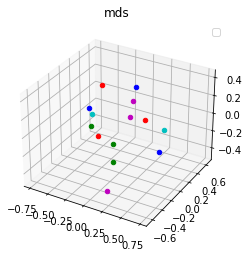

array([[-0.21907797, -0.03629087,  0.4178684 ],
       [ 0.12841307,  0.33937336, -0.0592631 ],
       [ 0.04809534, -0.51097958,  0.13683144],
       [-0.13481155,  0.05980987, -0.47562589],
       [-0.39836765,  0.00475813, -0.09996269],
       [-0.02211505, -0.09602011, -0.16811291],
       [ 0.11401336,  0.17733296,  0.37380951],
       [ 0.61952571, -0.144062  , -0.07067998],
       [-0.46554211,  0.05979419,  0.06178189],
       [ 0.44274297,  0.25245656, -0.06170967],
       [-0.17558746, -0.29982553,  0.22988358],
       [ 0.12349993,  0.09311996,  0.26033134],
       [ 0.15051866, -0.47453012, -0.46917149],
       [-0.19134258,  0.52936668, -0.18727747]])

In [43]:
mds_from_dissim_matrix(h5['rearrangedDissimMatrix'][0], h5['rearrangedReferenceAudioNames'][0], 3)

In [34]:
mds_dim = 3§
util.mds_from_dissim_matrix(h5['mds3d'][0], label_list, mds_dim, show_plot=True, title=title)

ValueError: array must be 2-dimensional and square. shape = (14, 3)